<a href="https://colab.research.google.com/github/lonespear/MA206/blob/main/dorta_thomas_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
install.packages("glmnet")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘iterators’, ‘foreach’, ‘shape’, ‘RcppEigen’




In [10]:
library(tidyverse)
library(glmnet)

In [32]:
df <- read_csv("dorta.csv")

Rows: 178 Columns: 677
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (10): Sport, MVI_PRE, MVIFreq_PRE, Ca_PRE, CaFreq_PRE, MVI_POST, MVIFre...
dbl (667): id, Pre_Average(n), Pre_Maximum(n), Pre_Minimum(n), Pre_Std Dev(n...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [39]:
# Load necessary libraries
library(dplyr)

# Define variable categories
psych_vars <- c(
  "PSQI_Baseline", "PSQI_Post", "PSQI_percent_change",
  "PSS_continuous_Baseline", "PSS_continuous_POST", "PSS_percent_change",
  "POMS2_Baseline_TensionAnxietyScore", "POMS2_POST_TensionAnxietyScore",
  "POMS2_Baseline_DepressionDejectionScore", "POMS2_POST_DepressionDejectionScore",
  "POMS2_Baseline_AngerHostilityScore", "POMS2_POST_AngerHostilityScore",
  "POMS2_Baseline_VigorScore", "POMS2_POST_VigorScore",
  "POMS2_Baseline_FatigueScore", "POMS2_POST_FatigueScore",
  "POMS2_Baseline_Confusion", "POMS2_POST_Confusion"
)

physical_vars <- c(
  "Height_cm_Baseline", "Weight_kg_Baseline", "Weight_kg_POST",
  "BMI_Baseline", "BMI_POST", "BMI_percent_change",
  "bodyfat_Baseline", "bodyfat_POST", "bodyfat_percent_change",
  "acft_point_score"
)

activity_vars <- c(
  "Step_Difference", "Step_Change",
  "VigorousPhysicalActivityDaysPerWeek", "VigorousPhysicalActivityTimeperdaymin",
  "ModeratePhysicalActivityDaysPerWeek", "ModeratePhysicalActivityTimeperdaymin",
  "Walkfor10minsatatimeDaysPerWeek", "Walkfor10minsatatimeTimeperdaymin",
  "TimeSpentSittingTimeperdaymin"
)

demographic_vars <- c(
  "Sex", "Age", "EthnicBackground", "Race",
  "YearinSchool", "HighestLevelofeducation",
  "DoyouhaveacontractforRangerSchool",
  "DoyouhaveacontractforSpecialForces",
  "DoyouhaveacontractforAirbirne"
)

nutrition_vars <- c(
  "AlcoholServings_PRE", "FruitSvgs_PRE", "VegetableSvgs_PRE",
  "WholeGrainSvgs_PRE", "FriedFoodSvgs_PRE", "SweetSvgs_PRE"
)

# Base vars (target + ID)
core_vars <- c("id", "POMS2_Baseline_TotalScore", "POMS2_POST_TotalScore")

# Combine all
vars_to_keep <- c(core_vars, psych_vars, physical_vars, activity_vars, demographic_vars, nutrition_vars)

# Subset data
df_sub <- df[, intersect(vars_to_keep, names(df))]

# Create POMS2 change outcome
df_sub$POMS2_Change <- df_sub$POMS2_POST_TotalScore - df_sub$POMS2_Baseline_TotalScore

In [44]:
# Step 1: Make a copy to work on
df_diff <- df_sub

# Step 2: Identify all _POST variables and find matching _Baseline or _PRE
post_vars <- names(df_diff)[grepl("_POST$", names(df_diff))]
diff_map <- list()

for (post in post_vars) {
  pre <- gsub("_POST$", "_Baseline", post)
  if (pre %in% names(df_diff)) {
    newname <- gsub("_POST$", "_Change", post)
    df_diff[[newname]] <- df_diff[[post]] - df_diff[[pre]]
    diff_map[[newname]] <- c(pre, post)
  } else {
    pre <- gsub("_POST$", "_PRE", post)
    if (pre %in% names(df_diff)) {
      newname <- gsub("_POST$", "_Change", post)
      df_diff[[newname]] <- df_diff[[post]] - df_diff[[pre]]
      diff_map[[newname]] <- c(pre, post)
    }
  }
}

# Drop all *_POST, *_PRE, *_Baseline columns except the core ones
df_diff_final <- df_diff %>%
  select(-matches("(_POST|_PRE|_Baseline)")) %>%
  relocate(POMS2_Change, .after = id)

# Step 4: Check what was created
print(names(df_diff_final))


 [1] "id"                                   
 [2] "POMS2_Change"                         
 [3] "PSQI_percent_change"                  
 [4] "PSS_percent_change"                   
 [5] "BMI_percent_change"                   
 [6] "bodyfat_percent_change"               
 [7] "acft_point_score"                     
 [8] "Step_Difference"                      
 [9] "Step_Change"                          
[10] "VigorousPhysicalActivityDaysPerWeek"  
[11] "VigorousPhysicalActivityTimeperdaymin"
[12] "ModeratePhysicalActivityDaysPerWeek"  
[13] "ModeratePhysicalActivityTimeperdaymin"
[14] "Walkfor10minsatatimeDaysPerWeek"      
[15] "Walkfor10minsatatimeTimeperdaymin"    
[16] "TimeSpentSittingTimeperdaymin"        
[17] "Sex"                                  
[18] "Age"                                  
[19] "EthnicBackground"                     
[20] "Race"                                 
[21] "YearinSchool"                         
[22] "HighestLevelofeducation"              
[23] "Doyo

In [55]:
# Step 1: Set up predictors and outcome
df_model <- df_diff_final  # or whatever your cleaned data frame is

df_model_complete <- df_model %>%
  select(-id) %>%
  drop_na()

# Now build x and y
x <- model.matrix(POMS2_Change ~ ., data = df_model_complete)[, -1]
y <- df_model_complete$POMS2_Change

28 x 1 sparse Matrix of class "dgCMatrix"
                                                 s1
(Intercept)                           -3.172746e+01
PSQI_percent_change                   -1.088687e-03
PSS_percent_change                     8.477395e-02
BMI_percent_change                    -1.345653e-01
bodyfat_percent_change                 3.615017e-02
acft_point_score                      -6.605814e-03
Step_Difference                        1.394992e-04
Step_ChangeIncrease                    1.984052e+00
VigorousPhysicalActivityDaysPerWeek   -4.857239e-01
VigorousPhysicalActivityTimeperdaymin  1.480237e-02
ModeratePhysicalActivityDaysPerWeek    4.133033e-01
ModeratePhysicalActivityTimeperdaymin  2.129468e-02
Walkfor10minsatatimeDaysPerWeek        1.704988e-01
Walkfor10minsatatimeTimeperdaymin     -8.807607e-04
TimeSpentSittingTimeperdaymin          1.246078e-02
Sex                                   -2.691165e+00
Age                                    1.035389e+00
EthnicBackground      

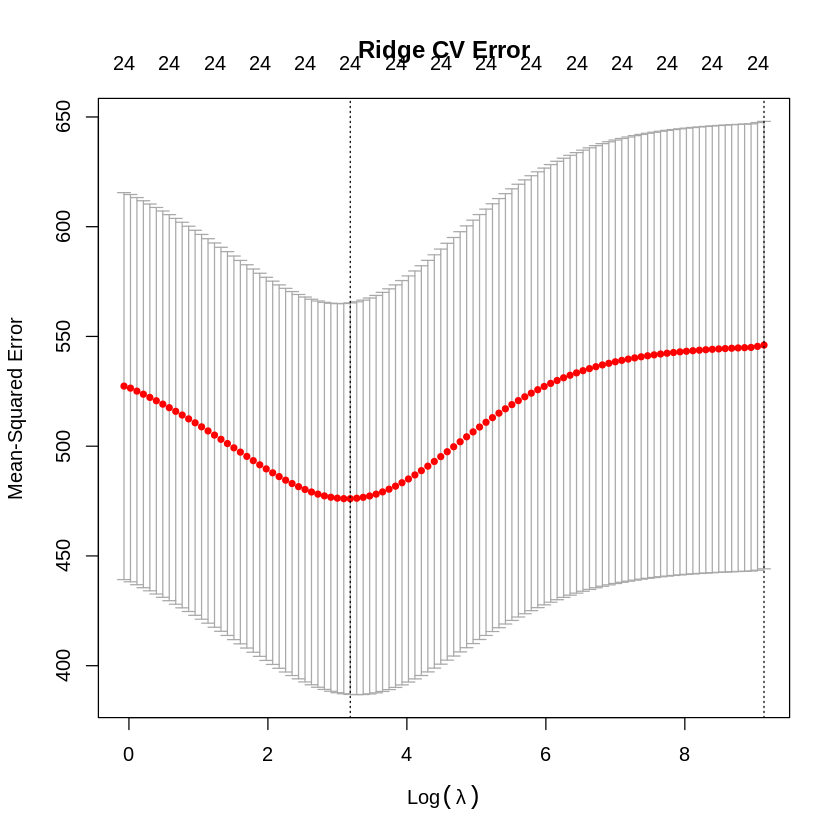

In [53]:
cv_ridge <- cv.glmnet(x, y, alpha = 0)
plot(cv_ridge, main = "Ridge CV Error")
coef(cv_ridge, s = "lambda.min")

[1] "(Intercept)"                          
[2] "Step_ChangeIncrease"                  
[3] "ModeratePhysicalActivityTimeperdaymin"
[4] "TimeSpentSittingTimeperdaymin"        
[5] "Sex"                                  
[6] "Age"                                  
[7] "HighestLevelofeducation"              
[8] "PSS_continuous_Change"                


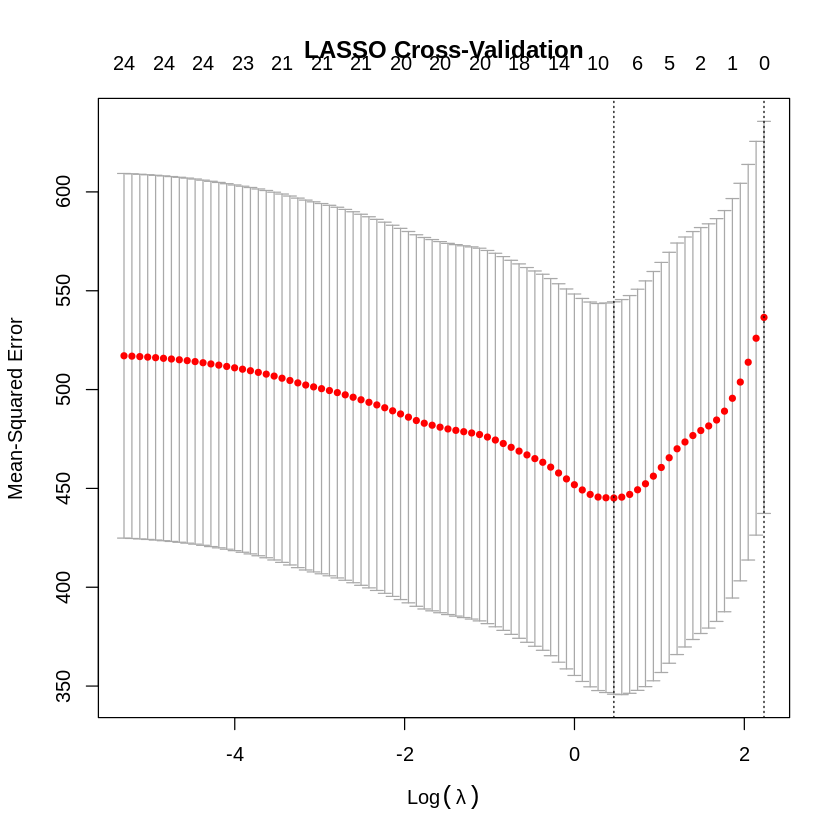

In [56]:
cv_lasso <- cv.glmnet(x, y, alpha = 1)

# Step 3: Plot CV error vs log(lambda)
plot(cv_lasso, main = "LASSO Cross-Validation")

# Step 4: Get best lambda and non-zero coefficients
best_lambda <- cv_lasso$lambda.min
lasso_coefs <- coef(cv_lasso, s = best_lambda)

# View selected variables (non-zero)
selected_vars <- rownames(lasso_coefs)[which(lasso_coefs != 0)]
print(selected_vars)


In [62]:
model_lr <- lm(POMS2_Change~.,data=df_model_complete)
summary(model_lr)


Call:
lm(formula = POMS2_Change ~ ., data = df_model_complete)

Residuals:
    Min      1Q  Median      3Q     Max 
-43.711 -11.615   0.587  11.410  76.754 

Coefficients: (3 not defined because of singularities)
                                        Estimate Std. Error t value Pr(>|t|)  
(Intercept)                           -5.203e+01  4.523e+01  -1.150   0.2529  
PSQI_percent_change                   -1.729e-02  4.985e-02  -0.347   0.7296  
PSS_percent_change                    -6.772e-03  2.021e-01  -0.034   0.9733  
BMI_percent_change                     2.029e+00  9.170e+00   0.221   0.8254  
bodyfat_percent_change                 1.955e-02  2.006e-01   0.097   0.9226  
acft_point_score                      -2.173e-02  6.203e-02  -0.350   0.7269  
Step_Difference                        4.621e-04  5.932e-04   0.779   0.4380  
Step_ChangeIncrease                    1.249e+00  7.717e+00   0.162   0.8718  
VigorousPhysicalActivityDaysPerWeek   -1.088e+00  1.557e+00  -0.699   0.486

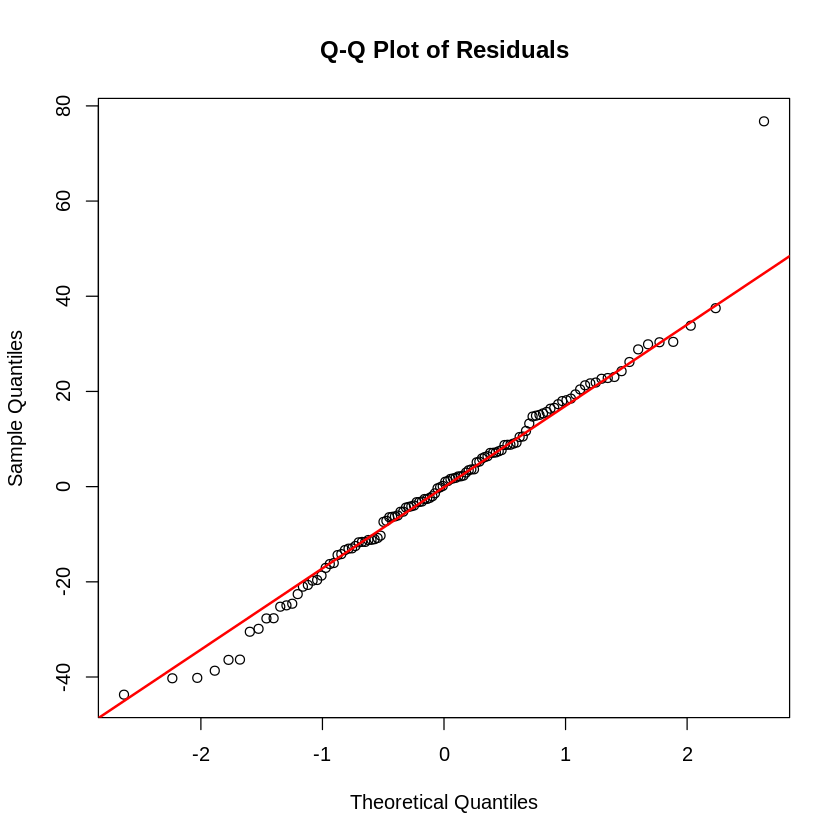

In [63]:
# Q-Q plot
qqnorm(residuals(model_lr), main = "Q-Q Plot of Residuals")
qqline(residuals(model_lr), col = "red", lwd = 2)

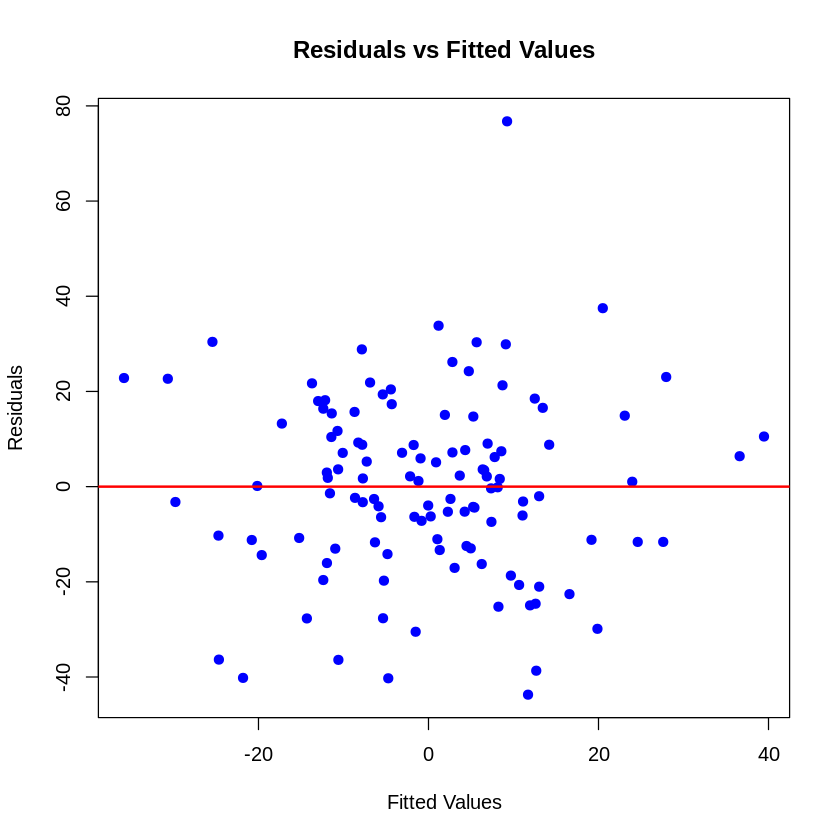

In [64]:
# Get fitted values and residuals
fitted_vals <- fitted(model_lr)
residuals_vals <- residuals(model_lr)

# Plot
plot(fitted_vals, residuals_vals,
     xlab = "Fitted Values",
     ylab = "Residuals",
     main = "Residuals vs Fitted Values",
     pch = 19, col = "blue")
abline(h = 0, col = "red", lwd = 2)

In [68]:
selected_vars <- c(
  "Step_Change",  # include the factor
  "ModeratePhysicalActivityTimeperdaymin",
  "TimeSpentSittingTimeperdaymin",
  "Sex",          # include the factor
  "Age",
  "HighestLevelofeducation",
  "PSS_continuous_Change"
)
df_selected <- df_model_complete[, c("POMS2_Change", selected_vars)]
df_selected$Sex <- as.factor(df_selected$Sex)
model_selected <- lm(POMS2_Change ~ ., data = df_selected)
summary(model_selected)



Call:
lm(formula = POMS2_Change ~ ., data = df_selected)

Residuals:
    Min      1Q  Median      3Q     Max 
-46.932 -10.203   1.508  11.218  81.551 

Coefficients:
                                       Estimate Std. Error t value Pr(>|t|)    
(Intercept)                           -64.13491   22.51298  -2.849  0.00524 ** 
Step_ChangeIncrease                     6.68277    3.84975   1.736  0.08538 .  
ModeratePhysicalActivityTimeperdaymin   0.06337    0.02349   2.697  0.00809 ** 
TimeSpentSittingTimeperdaymin           0.02598    0.01118   2.325  0.02192 *  
Sex2                                   -5.42124    4.27639  -1.268  0.20758    
Age                                     1.91051    1.13415   1.685  0.09491 .  
HighestLevelofeducation                 3.75467    3.26921   1.148  0.25326    
PSS_continuous_Change                   1.52053    0.32214   4.720 6.98e-06 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 20.09 on 110 degrees

In [69]:
df_selected$ModeratePhysicalActivityTimeperdaymin

[1]  60  30  30  45  90 150  30  60 120  93 120  60  60  30  60 120  90  20
 [19] 180  60  60   0  60  60  60  30  90  45 120  60 300  60   0   0  60  60
 [37] 120  30  60  55  30 420  60  45  60  90  30 120  30  45  60  30  60  30
 [55]  60  45  90  30  30  50  40  30 120  30  45  60  45  60  30  60  90  60
 [73]  60  15  60  90  30 720 240  30 120  90  60  60  60 180  75  60  60  60
 [91]  45   0  60  30 180  45  40  20  60   0  60  60  60  45  60  60 120  60
[109]  40   0  45  60  30  30  30  90  10  60

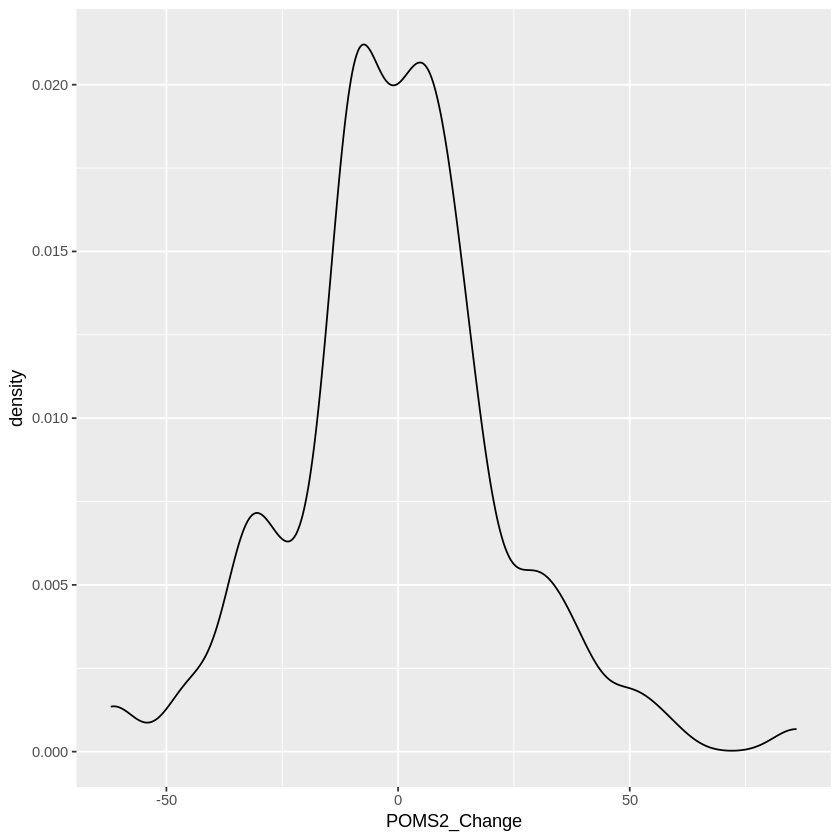

In [89]:
df_model_complete %>% ggplot(aes(x=POMS2_Change)) + geom_density(bw=5)

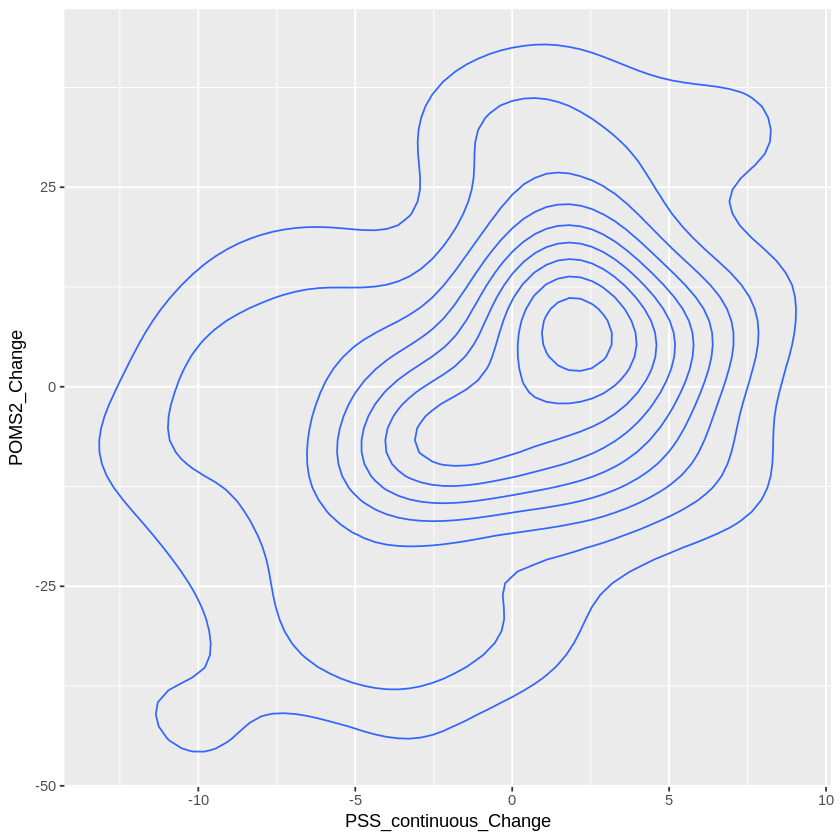

In [93]:
df_model_complete %>% ggplot(aes(x=PSS_continuous_Change, y=POMS2_Change)) + geom_density2d()